In [ ]:
import pandas  as pd
import numpy   as np
import matplotlib.pyplot as plt
import pickle
import shap
from xgboost                 import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split # Maybe RandomizedSearchCV is more interesting

In [ ]:
data = pd.read_csv('data/ECV_Th_2021.csv', delimiter='\t')

Columns (83,87,89,91,93,95,97,101,109,115,172,174,176,178) have mixed types.Specify dtype option on import or set low_memory=False.


In [58]:
data = data[~pd.isna(data['HH050'])]

In [ ]:
data = data.replace(' ', '')
data = data.replace('  ', '')
data = data.replace('', np.nan)
for column in range(data.shape[1]):
    if column == 1:
        continue
        
    if data.iloc[:,column].dtype in (int, object):
        data.iloc[:,column] = data.iloc[:,column].astype(float)


problematic_columns = (83,87,89,91,93,95,97,101,109,115,172,174,176,178)

for column in problematic_columns:
     data.iloc[:,column] = data.iloc[:,column].astype(float)

In [47]:
target_variable = 'HH050'
variables = list(data.keys())
variables = [x for x in variables if x not in (target_variable, 'HB010','HB020','HB030')]

y = data[target_variable]
X = data[variables]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [18]:
M = 10 # subsample size for the crossvalidation process
# M = X_train.shape[0]

params   = {
         'min_child_weight': [0.1, 1, 10],
         'max_depth': [4,8,16],
         'eta': [ 0.1, 0.3, 0.7],
         'subsample': [ 0.4,0.7,1],
         'use_label_encoder':[False],
         'nthread': [10],
         'n_estimators': [1,10,100]
         }

In [20]:
searcher_cv = GridSearchCV(estimator = XGBRegressor(), param_grid = params, cv=5)

searcher_cv.fit(X_train[:M], y_train[:M])
pickle.dump(searcher_cv.best_estimator_, open('Models/{}.sav'.format('cv_best'), 'wb'))

In [ ]:
pickle.dump(searcher_cv.best_estimator_, open('Models/{}.sav'.format('cv_best'), 'wb'))

In [49]:
best_cv = pickle.load(open('Models/{}.sav'.format('cv_best'), 'rb'))
best_params = best_cv.get_params()

xgb_regressor = XGBRegressor(**best_params)
xgb_regressor.fit(X_train,y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.7, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.699999988,
             max_delta_step=0, max_depth=4, min_child_weight=0.1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=10, nthread=10,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.4,
             tree_method='exact', use_label_encoder=False,
             validate_parameters=1, ...)

In [50]:
explainer   = shap.TreeExplainer(xgb_regressor)
shap_values = explainer.shap_values(X_train, check_additivity=False)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


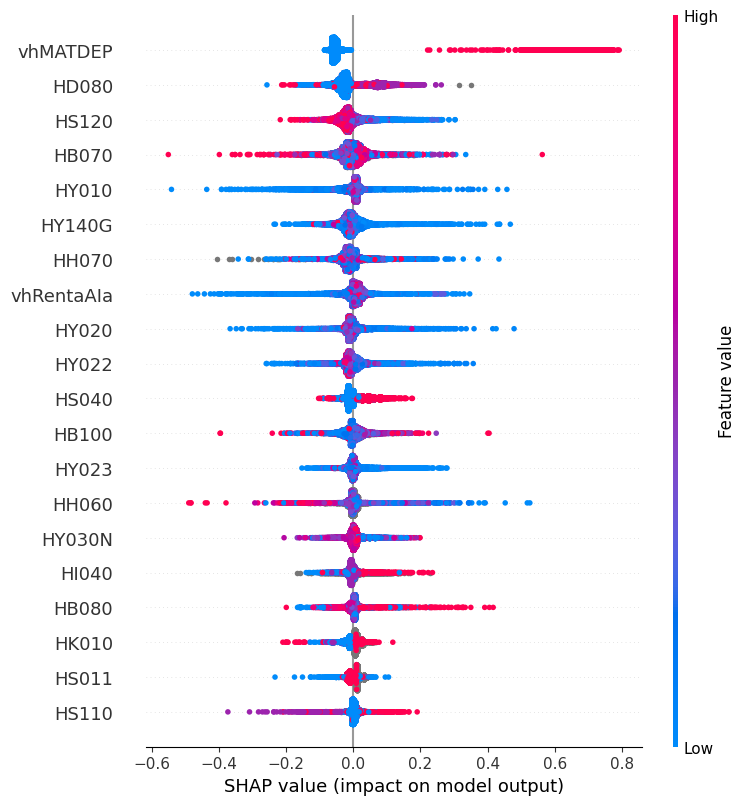

In [51]:
shap.summary_plot(shap_values, X_train[variables])

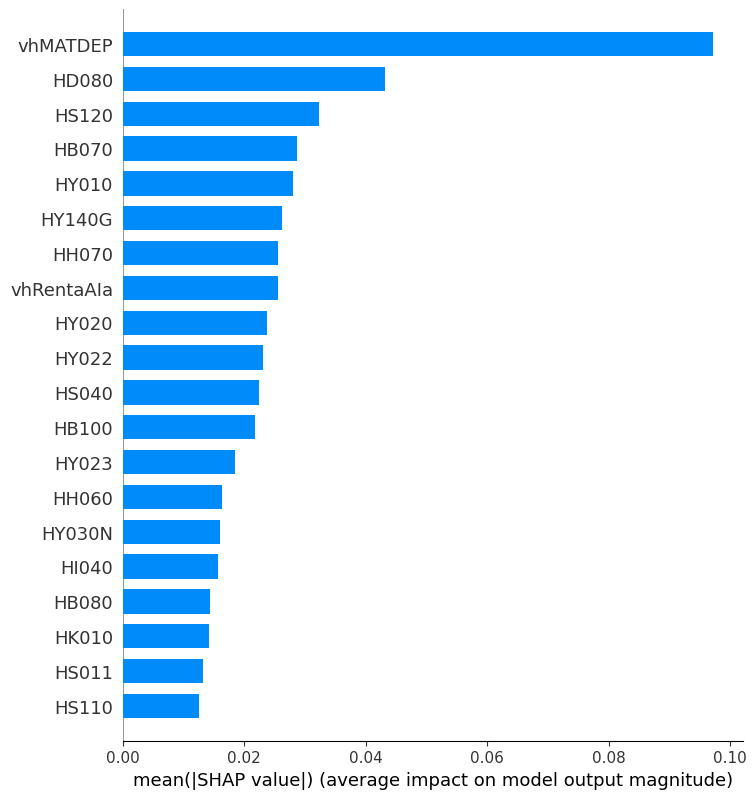

In [52]:
shap.summary_plot(shap_values, X_train[variables], plot_type='bar')